##  Imports 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

##  1. CSV setup 

In [ ]:
# -------------------------------------
# 1. Load and prepare raw CSV
# -------------------------------------
file_path = '../test_csv/motor_temp_high.csv'  # Change as needed
df_raw = pd.read_csv(file_path)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw['csv_index'] = df_raw.index  # 🔐 lock raw index early

# -------------------------------------
# 2. Filter by sensor (temperature)
# -------------------------------------
df = df_raw[df_raw['sensor'] == 'temperature'].copy()

# -------------------------------------
# 3. Detect numeric features
# -------------------------------------
feature_cols = df.select_dtypes(include=[float, int]).columns.tolist()
feature_cols = [col for col in feature_cols if col != 'csv_index']

## 2. Group by states

In [ ]:
# -------------------------------------
# 4. Group by state
# -------------------------------------
grouped = df.groupby('state', sort=False)
print("📋 Detected states:", list(grouped.groups.keys()))

all_state_results = []

# -------------------------------------
# 5. Sequence creation with index tracking
# -------------------------------------
def create_sequences(data, index_ref, window=20):
    sequences, start_indices, end_indices = [], [], []
    for i in range(len(data) - window):
        sequences.append(data[i:i+window])
        start_indices.append(index_ref[i])
        end_indices.append(index_ref[i + window - 1])
    return np.array(sequences), start_indices, end_indices

# -------------------------------------
# 6. Loop through each state and train model
# -------------------------------------
for state, group in grouped:
    print(f"\n🚀 Processing state: {state}")
    data = group.copy()

    if not all(col in data.columns for col in feature_cols):
        print(f"⚠️ Skipping state '{state}' — missing features.")
        continue

    data_features = data[feature_cols].values
    index_ref = data['csv_index'].values

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_features)

    seq_len = 20
    X, start_indices, end_indices = create_sequences(scaled, index_ref, seq_len)
    if len(X) < 100:
        print(f"⚠️ Not enough sequences in state '{state}', skipping...")
        continue

    # Split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    start_test = start_indices[split:]
    end_test = end_indices[split:]

📋 Detected states: ['idle', 'off', 'run']

🚀 Processing state: idle
⚠️ Not enough sequences in state 'idle', skipping...

🚀 Processing state: off

🚀 Processing state: run


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
📊 Threshold (95th percentile): 0.028122

🔍 Verifying timestamp match for first result:
Result timestamp: 2025-04-07 20:05:00
Raw CSV timestamp at index 1205: 2025-04-07 20:05:00

✅ Final deduplicated anomaly results:


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly
0,1186,1205,2025-04-07 20:05:00,run,0.020117,0
1,1187,1206,2025-04-07 20:06:00,run,0.018707,0
2,1188,1207,2025-04-07 20:07:00,run,0.017164,0
3,1189,1208,2025-04-07 20:08:00,run,0.015881,0
4,1190,1209,2025-04-07 20:09:00,run,0.018096,0
5,1191,1210,2025-04-07 20:10:00,run,0.018964,0
6,1192,1211,2025-04-07 20:11:00,run,0.018623,0
7,1193,1212,2025-04-07 20:12:00,run,0.016911,0
8,1194,1213,2025-04-07 20:13:00,run,0.017740,0
9,1195,1214,2025-04-07 20:14:00,run,0.018591,0


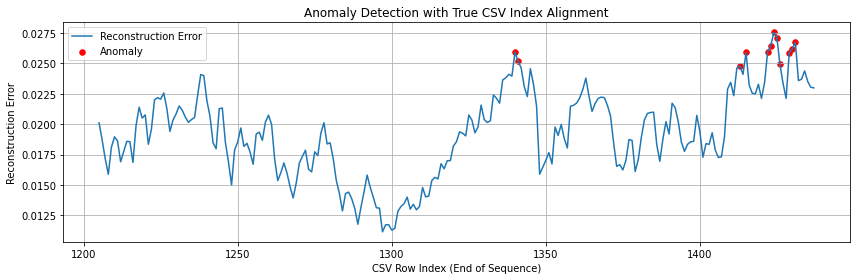

In [64]:
# Build LSTM Autoencoder
model = Sequential(
    [
        LSTM(
            64,
            activation="relu",
            input_shape=(X.shape[1], X.shape[2]),
            return_sequences=False,
        ),
        RepeatVector(X.shape[1]),
        LSTM(64, activation="relu", return_sequences=True),
        TimeDistributed(Dense(X.shape[2])),
    ]
)
model.compile(optimizer=Adam(1e-3), loss="mse")
model.fit(X_train, X_train, epochs=10, batch_size=32, verbose=0)

# Predict
X_pred = model.predict(X_test)
errors = np.mean(np.abs(X_pred - X_test), axis=(1, 2))
threshold = np.percentile(errors, 95)
print(f"📊 Threshold (95th percentile): {threshold:.6f}")

# Timestamp lookup from df (NOT df_raw)
result_df = pd.DataFrame(
    {
        "start_csv_index": df.loc[start_test, "csv_index"].values,
        "end_csv_index": df.loc[end_test, "csv_index"].values,
        "timestamp": df.loc[end_test, "timestamp"].values,
        "state": state,
        "reconstruction_error": errors,
        "is_anomaly": (errors > threshold).astype(int),
    }
)

all_state_results.append(result_df)

# -------------------------------------
# 7. Combine and deduplicate
# -------------------------------------
all_anomalies_df = pd.concat(all_state_results, ignore_index=True)
all_anomalies_df = all_anomalies_df.drop_duplicates(
    subset=["start_csv_index", "end_csv_index"]
)
all_anomalies_df = all_anomalies_df.sort_values(by="end_csv_index")

# -------------------------------------
# 8. Debug print for timestamp alignment
# -------------------------------------
first_anom = all_anomalies_df.iloc[0]
actual_ts = df_raw.loc[first_anom["end_csv_index"], "timestamp"]
print(f"\n🔍 Verifying timestamp match for first result:")
print(f"Result timestamp: {first_anom['timestamp']}")
print(f"Raw CSV timestamp at index {first_anom['end_csv_index']}: {actual_ts}")

# -------------------------------------
# 9. Display results
# -------------------------------------
print("\n✅ Final deduplicated anomaly results:")
display(all_anomalies_df.head(10))

# -------------------------------------
# 10. Plot anomalies
# -------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(
    all_anomalies_df["end_csv_index"],
    all_anomalies_df["reconstruction_error"],
    label="Reconstruction Error",
)
plt.scatter(
    all_anomalies_df[all_anomalies_df["is_anomaly"] == 1]["end_csv_index"],
    all_anomalies_df[all_anomalies_df["is_anomaly"] == 1]["reconstruction_error"],
    color="red",
    label="Anomaly",
    s=30,
)
plt.title("Anomaly Detection with True CSV Index Alignment")
plt.xlabel("CSV Row Index (End of Sequence)")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()